# Pymetry Regression

## Import and Initialize

In [1]:
import sys

sys.path.append("/opt/symetry/python")

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

import pymetry as pym
import pymetry.project as pym_prj
import pymetry.utilities.jobs as pym_job
import pymetry.utilities.utils as pym_ut
import pymetry.explore as pym_exp

import sklearn.metrics as skmetrics
import sklearn.model_selection as skms

In [2]:
pym.init_conf({
    "SERVER" : 'YOUR_SYMETRYML_ENDPOINT',
    "SYM_KEY_ID" : "SYMETRY_USER",
    "SYM_SECRET_KEY" : "SYMETRY_SECRET_KEY",
})

## Read the data

### Iris Dataset

In [3]:
DATA_FILE = "../../../data/Iris_data.csv"

df = pd.read_csv(DATA_FILE)

# Dropping Columns to avoid Singular Matrix Error
columns_drop = ['sepal_lengt_b2',
                'sepal_width_b2',
                'petal_length_b2',
                'petal_width_b2',
                'Iris_versicolor',
                'Iris_virginica',
                'Iris_setosa']

df = df.drop(columns_drop, 
             axis=1)

# Get list of Attributes & Target
attributes_target = df.columns.tolist()

In [4]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,sepal_lengt_b1,sepal_width_b1,petal_length_b1,petal_width_b1
0,4.3,3.0,1.1,0.1,1,0,1,1
1,4.8,3.0,1.4,0.1,1,0,1,1
2,4.9,3.1,1.5,0.1,1,0,1,1
3,4.9,3.1,1.5,0.1,1,0,1,1
4,4.9,3.1,1.5,0.1,1,0,1,1


### Create Training & Test set

In [5]:
train_df, test_df = skms.train_test_split(df, 
                                          test_size=0.2, 
                                          random_state=42)

print(train_df.shape)
print(test_df.shape)

smldf_train = pym_ut.pandas_df_to_sml_json(pandas_df=train_df)
smldf_test = pym_ut.pandas_df_to_sml_json(pandas_df=test_df)

(120, 8)
(30, 8)


## Create and Learn Project

In [6]:
prj_name = 'reg_example'
project_type = 'cpu'

rsp = pym_prj.create_project(pid=prj_name, 
                             project_type=project_type)
print(rsp.content)

b'{"statusCode":"CREATED","statusString":"Project Created with id:reg_example","values":{}}'


In [7]:
%%time

client_id = "pymetry-ipynb"

rsp = pym_prj.stream_data_to_project(pid=prj_name, 
                                     sml_dataframe=smldf_train, 
                                     client_id='pymetry')
print(rsp.content)

b'{"statusCode":"OK","statusString":"OK","values":{}}'
CPU times: user 4.69 ms, sys: 2.42 ms, total: 7.11 ms
Wall time: 27 ms


## Explore the data

In [8]:
def get_lincorr_new(project_name, attr_names):
    # Create ExploreContext
    explore_context = {
        "values": []
    }
    counting = 1
    for i in range(len(attr_names)):
        for j in range(i+1):

            attr_i = attr_names[i]
            attr_j = attr_names[j]
            attr_pair = [attr_i, attr_j]
            explore_context['values'].append({
                "targets": [],
                "inputAttributeNames": attr_pair
            })

    # Make REST call
    res = pym_exp.get_exploration(project_name, 
                                  explore_context, 
                                  metric_type="bi")
    bivar_stats = json.loads(res.content)

    # Extract corresponding correlation values
    lin_corr = []
    idx = 0
    for i in range(len(attr_names)):
        temp = []
        for _ in range(i+1):
            pair_stats = bivar_stats['values']['KSVDMap']['values'][idx]
            temp.append(pair_stats["linCorr"])
            idx += 1
        lin_corr.append(temp)

    return lin_corr

In [9]:
## Extract the Full Correlation Matrix

# cols = inputs + TARGETS_IGNORE
cols = attributes_target
cor_matrix = get_lincorr_new(prj_name, cols)

# cor_matrix is only the lower triangular matrix. 
# convert it to full matrix
C = np.zeros((len(cor_matrix), len(cor_matrix)))
for i, r in enumerate(cor_matrix):
    C[i, 0:len(r)] = r

C = C + C.T - np.identity(C.shape[0])
cor_df = pd.DataFrame(C, columns=cols, index=cols)

In [10]:
cor_df

,sepal_length,sepal_width,petal_length,petal_width,sepal_lengt_b1,sepal_width_b1,petal_length_b1,petal_width_b1
sepal_length,1.0000,-0.0537,0.8588,0.7993,-0.8385,0.0914,-0.7697,-0.7057
sepal_width,-0.0537,1.0000,-0.3870,-0.3252,0.1377,-0.7561,0.3236,0.5690
petal_length,0.8588,-0.3870,1.0000,0.9605,-0.7664,0.3321,-0.9011,-0.9232
petal_width,0.7993,-0.3252,0.9605,1.0000,-0.7230,0.2632,-0.8758,-0.8886
sepal_lengt_b1,-0.8385,0.1377,-0.7664,-0.7230,1.0000,-0.0868,0.7391,0.6183
sepal_width_b1,0.0914,-0.7561,0.3321,0.2632,-0.0868,1.0000,-0.2357,-0.4747
petal_length_b1,-0.7697,0.3236,-0.9011,-0.8758,0.7391,-0.2357,1.0000,0.8367
petal_width_b1,-0.7057,0.5690,-0.9232,-0.8886,0.6183,-0.4747,0.8367,1.0000


### Get Index of Attribute Names from Pymetry Project

In [11]:
rsp = pym_prj.get_project_info(prj_name)
print(rsp.json['values']['smlInfo']['attributeIndexes'])
print(rsp.json['values']['smlInfo']['attributeNames'])

[0, 1, 2, 3, 4, 5, 6, 7]
['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'sepal_lengt_b1', 'sepal_width_b1', 'petal_length_b1', 'petal_width_b1']


In [12]:
# petal_length
variable = "2"
exp_out_two = pym_exp.get_univariate_stats(pid=prj_name,
                                           variable=variable)
# petal_width
variable = "3"
exp_out_three = pym_exp.get_univariate_stats(pid=prj_name,
                                             variable=variable)
# petal_length_b1
variable = "6"
exp_out_six = pym_exp.get_univariate_stats(pid=prj_name,
                                           variable=variable)

Plotting Distributions


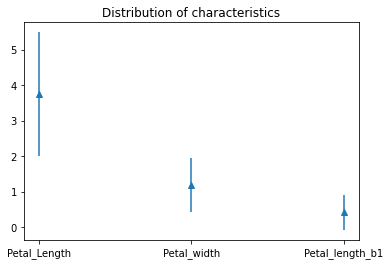

In [13]:
# Measuring some univariate statistics

print("Plotting Distributions")
petall_v = exp_out_two['stddev']
petall_m = exp_out_two['mean']
petalw_v = exp_out_three['stddev']
petalw_m = exp_out_three['mean']
petall_b1_v = exp_out_six['stddev']
petall_b1_m = exp_out_six['mean']

x = ['Petal_Length', 'Petal_width', 'Petal_length_b1']
e = np.array([petall_v, petalw_v, petall_b1_v])
y = np.array([petall_m, petalw_m, petall_b1_m])
plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.title('Distribution of characteristics')
plt.show()

In [14]:
def plot_corr(corr, size=9):

    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), 
               corr.columns, 
               rotation=90)
    plt.yticks(range(len(corr.columns)), 
               corr.columns)
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, 
                        ticks=[-1, 0, 1], 
                        aspect=40, 
                        shrink=.8)

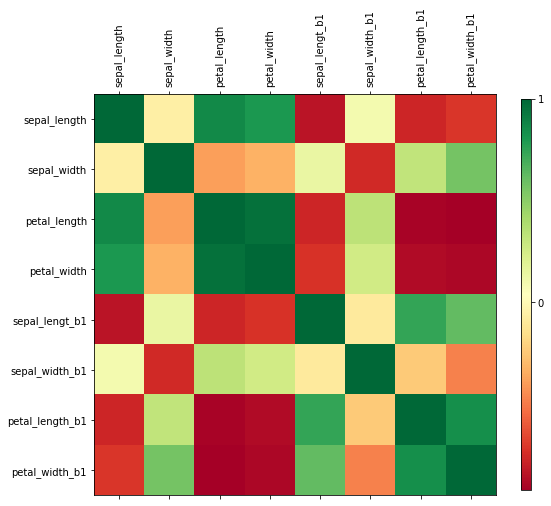

In [15]:
plot_corr(cor_df)

## Build Regression Model

In [16]:
%%time

model_name = 'regression_one'
ml_context = {"targets": ["0"],
              "inputAttributes": ["1", "2", "3", "4", "5", "6", "7"]}
rsp = pym_prj.build_model(ml_context=ml_context,
                          pid=prj_name,
                          modelid=model_name,
                          algo='mlr')
print(rsp.content)
pym_job.wait_for_job_finish(rsp)

b'{"statusCode":"ACCEPTED","statusString":"Job Created","values":{}}'
{'statusCode': 'OK', 'statusString': 'Job is finished', 'values': {}}
CPU times: user 14 ms, sys: 3.93 ms, total: 17.9 ms
Wall time: 4.04 s


## Prediction Output

In [17]:
predict_out = pym_prj.predict_df(pid=prj_name,
                                 modelid=model_name,
                                 sml_dataframe=smldf_test)

### Plot the output: Prediction, Actual & Residuals

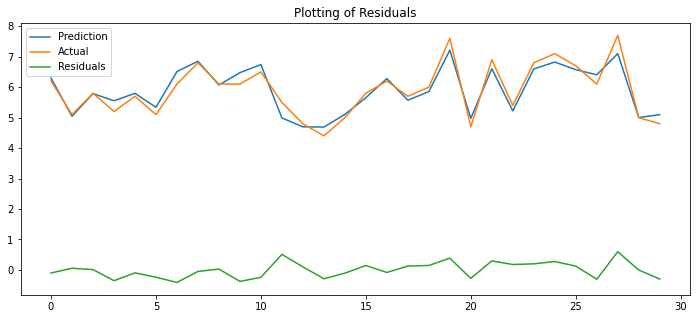

In [18]:
df1 = pd.DataFrame(predict_out.json['values']['KSVSMap']['values'])
df1['res'] = df1['res'].astype(float)

data = {'Prediction': df1['res'].values, 
        'Actual': test_df['sepal_length'].values}
df1 = pd.DataFrame(data)
df1['Residuals'] = df1['Actual'] - df1['Prediction']
df1.plot(figsize=[12, 5], 
         kind='line', 
         title='Plotting of Residuals');

## Clear

In [ ]:
clear = True

if clear:
    # Remove All Projects
    rsp = pym_prj.delete_project(pid=prj_name)
    print(rsp.content)